In [1]:
import sys,os
import numpy as np
import pandas as pd
import random
import math
from time import time
from datetime import datetime


import jenkspy

import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
### Binarization Step Parameters ###
bin_method = "GMM" # binarization method should be "GMM" or "Jenks"
snr_pval = 0.05
min_n_samples = 1 # define authomatically if -1

### Feature clustering parameters ###
min_SNR = 0.5
clust_method = "WGCNA" # feature clustering method "WGCNA" or "DESMOND"

if clust_method == "WGCNA":
    p1 = 10 # power for correlation matrix [1-30]
    p2 = 10 # power for tree cutof height 
    
if clust_method == "DESMOND":
    # PGM parameters
    alpha = 10.0 
    beta_K = 1.0

    # convergence
    max_n_steps= 50
    n_steps_for_convergence = 10

# seed - makes sense only for GMM and DESMOND - TBD
seed = 42


### input and output  ###

verbose = True
plot_all = True

# whether to load and to save binarized data
load = False
save = True



# Inputs:

 * z-score normalized gene expressions: 
      - tab-separated (.tsv) file with gene names in rows and sample/patient names in columns
      - row means should be 0, row std. = 1
    
# Outputs:
 * saves outputs to out_dir
 * binarized up- and donw- regulated genes: 
     - [basename].[GMM|Jenks].binarized_UP.tsv
     - [basename].[GMM|Jenks].binarized_DOWN.tsv
 * if binarization method is WGCNA, the results of WGCNA run are saved:
     - [basename].[GMM|Jenks].binarized_UP.modules.tsv
     - [basename].[GMM|Jenks].binarized_DOWN.modules.tsv
 * a table with biclusters: 
     - [basename].bin=[GMM|Jenks],clust=[WGCNA|DESMOND].biclusters.tsv


In [6]:
out_dir = os.getcwd()+"/tmp_results/"
basename = "TCGA-BRCA"

data_dir = "/home/olya/TUM/DESMOND/datasets_DESMOND2/"
exprs_file = data_dir + "TCGA-BRCA_945.Xena.log2RSEM_norm_z.14K_genes.tsv" # z-normalized expressions

In [7]:
start_time = time()

if basename:
    basename = basename
else: 
    [date_h,mins] = str(datetime.today()).split(":")[:2]
    [date, hs] = date_h.split()
    basename = "results_"+hs+":"+mins+"_"+date 
    
if verbose:
    print("Save output files to:",out_dir + basename + "*", file = sys.stdout)
    
# read inputs
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)
# TBD:
#  - check z-scores
#  - check missing values
#  - check min. samples: x < 40 - warning, x<=10 makes no sense 

# define minimal number of samples
if min_n_samples == -1:
    min_n_samples = round(min(0.5*exprs.shape[1],max(10,0.01*exprs.shape[1])))
if verbose:
    print("Mininal number of samples in a bicluster:",min_n_samples ,file=sys.stdout)
if min_n_samples < 10:
    print("min_n_samples is recommended to be >= 10", file= sys.stderr)

Save output files to: /home/olya/TUM/DESMOND/DESMOND2/tmp_results/TCGA-BRCA*
Mininal number of samples in a bicluster: 1


min_n_samples is recommended to be >= 10


# 1) Binarize individual features

### Find the trend between SNR and bicluster size

1) for all sizes [min_n_samples, int(N/2)+ min_n_samples], generate splits of random samples drawn from normal distributions

2) find SNR_thr(size) for a p-value cutoff, e.g. p_val =0.01; get_snr_thr is a function of bicluser size 


### Binarize expressions:

 * Jenks or GMM binarization
 * filtering by sample nubmer and SNR
     - n_samples =< min_n_samples, and
     - SNR > SNR_thr(n_samples)


Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 945, number of samples in bicluster: 1 - 473, n_permutations: 105


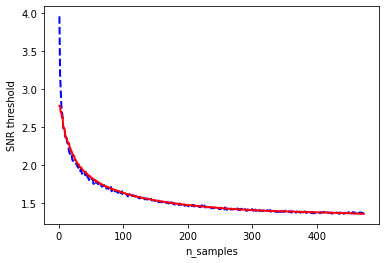

	SNR thresholds for individual features computed in 6.09 seconds
		genes processed: 0
Gene APOBEC3A: SNR=-1.42, pos=321, neg=0


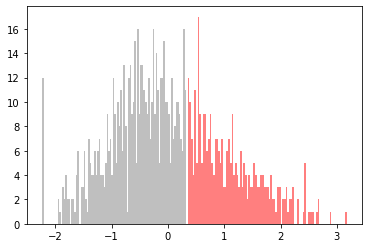

		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
		genes processed: 4000
Gene ERBB2: SNR=-2.3, pos=90, neg=0


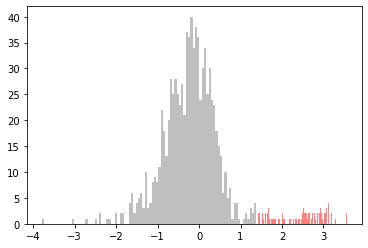

Gene ESR1: SNR=2.18, pos=0, neg=237


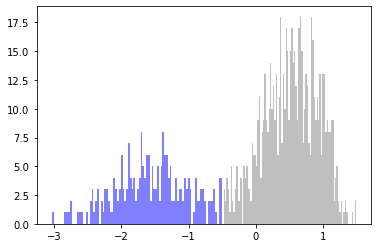

Gene FOXA1: SNR=2.24, pos=0, neg=175


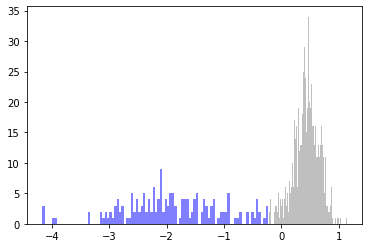

		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
Gene PIK3R2: SNR=-5.18, pos=0, neg=458


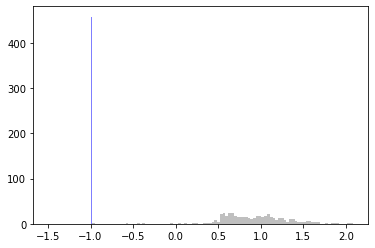

		genes processed: 10000
		genes processed: 11000
		genes processed: 12000
		genes processed: 13000
		genes processed: 14000
	GMM binarization for 14986 features completed in 126.89 s
	up-regulated features: 1234
	down-regulated features: 1154
	ambiguous features: 0
	binarization runtime: 132.99 s
Binarized gene expressions are saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA.GMM.binarized_UP.tsv
Binarized gene expressions are saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA.GMM.binarized_DOWN.tsv


In [8]:
from method import binarize

show_fits = [ "FOXA1","ESR1","ERBB2",'APOBEC3A',"PIK3R2","ENSG00000235023"] + ["ENSG00000107485",  "ENSG00000101000",  "ENSG00000197380",  
         "ENSG00000167779",  "ENSG00000105928",  "ENSG00000097033", 
         "ENSG00000148734",  "ENSG00000196581"] # some exmaple genes

    
binarized_expressions = binarize(out_dir+"/"+basename, exprs=exprs,
                                 method=bin_method, save = save, load=load,
                                 min_n_samples = min_n_samples, snr_pval = snr_pval,
                                 plot_all = plot_all,show_fits =show_fits,
                                 verbose= verbose,seed=seed)

    

# Step 2. Group features into modules

Input: binarized inputs
Output: modules - sets of features with the same 1/0 profiles

 - feature clustering: choose WGCNA or DESMOND 
 - runs for up- and down-regulated features separately
 



###    WGCNA:

In [9]:
#clust_method = "WGCNA"
if clust_method == "WGCNA":
    from method import run_WGCNA
    
    clustering_results = {}
    for d in ["UP","DOWN"]:
        fname = out_dir+"/"+basename+ "."+bin_method+".binarized_"+d +".tsv"
        clustering_results[d] = run_WGCNA(fname,p1=p1,p2=p2, verbose = verbose)

Running WGCNA for /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA.GMM.binarized_UP.tsv ...
	WGCNA runtime: modules detected in 10.81 s.
	67 modules and 274 not clustered genes
Running WGCNA for /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA.GMM.binarized_DOWN.tsv ...
	WGCNA runtime: modules detected in 9.56 s.
	35 modules and 208 not clustered genes


### DESMOND:

In [10]:
#clust_method = "DESMOND"
if clust_method == "DESMOND":
    from pgm import run_sampling
    # PGM parameters
    alpha = 2.0 # convergence fails from 0.25; 0.33 is still Ok
    beta_K = 1

    # convergence
    max_n_steps= 50
    n_steps_averaged = 10
    n_points_fit=10
    n_steps_for_convergence = 10

    clustering_results ={}
    for d in ["UP","DOWN"]:
        exprs_bin = binarized_expressions[d]
        genes = exprs_bin.columns.values
        clustering_results[d] = run_sampling(exprs_bin,alpha=alpha,beta_K=beta_K,f=0.51,
                    max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged,
                    n_points_fit = n_points_fit, tol = 0.1,
                    n_steps_for_convergence = n_steps_for_convergence,
                    verbose =True,plot_all=plot_all)

In [11]:
"""
### 3. Split each module to bicluster and background -> changed to k-means

 * Jenks is th only option, GMM makes no sense for small biclusters of 2-3-5 genes 
 * based on 1/0 profile
 * if min_SNR is set, remove genes not matching with the rest of bicluster
 
 
from method import modules2biclsuters_jenks

biclusters, not_clustered_features = modules2biclsuters_jenks(clustering_results,exprs,binarized_expressions,
                                                     min_SNR = min_SNR,min_n_samples=min_n_samples,
                                                     snr_pval=snr_pval,
                                                     bin_method = bin_method, clust_method = clust_method,
                                                     result_file_name = out_dir+basename,
                                                     directions=["UP","DOWN"],
                                                     plot=False,verbose = False)"""

'\n### 3. Split each module to bicluster and background -> changed to k-means\n\n * Jenks is th only option, GMM makes no sense for small biclusters of 2-3-5 genes \n * based on 1/0 profile\n * if min_SNR is set, remove genes not matching with the rest of bicluster\n \n \nfrom method import modules2biclsuters_jenks\n\nbiclusters, not_clustered_features = modules2biclsuters_jenks(clustering_results,exprs,binarized_expressions,\n                                                     min_SNR = min_SNR,min_n_samples=min_n_samples,\n                                                     snr_pval=snr_pval,\n                                                     bin_method = bin_method, clust_method = clust_method,\n                                                     result_file_name = out_dir+basename,\n                                                     directions=["UP","DOWN"],\n                                                     plot=False,verbose = False)'

# 3. K-means to split modules into biclusters and background

In [12]:
from method import genesets2biclusters,  write_bic_table

In [13]:
all_biclusters = []
for d in ["UP","DOWN"]:
    genes = binarized_expressions[d].columns.values
    exprs_np = exprs.loc[genes,:]
    ints2g_names = exprs_np.index.values
    ints2s_names = exprs_np.columns.values
    exprs_np = exprs_np.values
    exprs_sums = exprs_np.sum(axis=1)
    exprs_sq_sums = np.square(exprs_np).sum(axis=1)
    N = exprs.shape[1]
    exprs_data = N, exprs_sums, exprs_sq_sums
    
    modules = clustering_results[d][0]
    genes = dict( zip(genes,range(0,len(genes))))
    res = genesets2biclusters(modules, genes, exprs_np, exprs_data,ints2g_names,ints2s_names,
                            min_SNR = min_SNR,min_n_samples=min_n_samples, min_n_genes=2,
                            verbose = False)
    res = pd.DataFrame.from_dict(res).T
    res.set_index("id",inplace = True)
    print(res.shape)
    all_biclusters.append(res)
all_biclusters = pd.concat(all_biclusters,axis =0)
all_biclusters.index = range(0,all_biclusters.shape[0])

from method2 import write_bic_table
suffix  = ".bin="+bin_method+",clust="+clust_method
all_biclusters = all_biclusters.sort_values(by=["avgSNR"],ascending=[False])
write_bic_table(all_biclusters, out_dir+basename+suffix+".biclusters.tsv")
all_biclusters.head(20)

(66, 8)
(33, 8)


,gene_ids,n_genes,sample_ids,n_samples,avgSNR,direction,genes,samples
65,"{1218, 1220}",2,"{1, 514, 7, 519, 9, 11, 524, 14, 527, 16, 529,...",281,1.91705,UP,"{ZIC1, ZIC4}","{TCGA-A7-A5ZV-01, TCGA-B6-A0RT-01, TCGA-AC-A2Q..."
32,"{889, 114}",2,"{2, 3, 5, 8, 11, 13, 14, 19, 21, 23, 25, 26, 2...",406,1.76149,UP,"{PWP2, C21orf33}","{TCGA-B6-A0RT-01, TCGA-B6-A0I5-01, TCGA-AR-A24..."
51,"{780, 271}",2,"{514, 6, 523, 16, 529, 27, 28, 29, 541, 31, 54...",129,1.55528,UP,"{OOEP, DDX43}","{TCGA-B6-A0RT-01, TCGA-BH-A0WA-01, TCGA-AO-A0J..."
97,"{466, 467}",2,"{513, 515, 6, 8, 520, 522, 523, 13, 525, 16, 1...",206,1.54332,DOWN,"{HIST3H2BB, HIST3H2A}","{TCGA-E2-A2P6-01, TCGA-AC-A3QQ-01, TCGA-HN-A2N..."
47,"{856, 787, 245}",3,"{0, 5, 517, 520, 525, 527, 17, 532, 26, 556, 4...",137,1.34679,UP,"{ORAOV1, PPFIA1, CTTN}","{TCGA-A7-A5ZV-01, TCGA-E2-A2P6-01, TCGA-BH-A0C..."
62,"{769, 524, 558, 527, 529}",5,"{4, 7, 12, 19, 20, 25, 27, 28, 29, 31, 32, 36,...",392,1.23263,UP,"{OAS1, IFIT1, IFI6, ISG15, IFI27}","{TCGA-B6-A0RT-01, TCGA-D8-A1JA-01, TCGA-AR-A24..."
18,"{770, 771, 714, 525, 206, 526, 530, 53, 533}",9,"{7, 12, 19, 20, 22, 25, 27, 28, 29, 31, 36, 37...",375,1.14085,UP,"{IFNL1, APOBEC3A, CMPK2, OAS2, IFI44L, IFIT3, ...","{TCGA-B6-A0RT-01, TCGA-D8-A1JA-01, TCGA-AR-A24..."
86,"{165, 1064, 1066, 76, 653, 174, 175, 176, 813,...",14,"{4, 6, 7, 9, 10, 11, 18, 26, 29, 30, 31, 32, 3...",399,1.12771,DOWN,"{RAD51, UBE2T, GINS1, AURKA, CDC45, CDCA5, CDC...","{TCGA-AR-A2LM-01, TCGA-B6-A0I5-01, TCGA-D8-A1J..."
63,"{657, 589, 927}",3,"{514, 525, 14, 527, 16, 529, 19, 20, 22, 23, 5...",195,1.11707,UP,"{RIOK1, LYAR, KIAA0020}","{TCGA-B6-A0RT-01, TCGA-AC-A2QH-01, TCGA-BH-A0W..."
78,"{768, 1042, 28, 421, 1063, 41, 557, 696, 454, ...",21,"{2, 7, 9, 13, 26, 27, 29, 30, 31, 34, 42, 44, ...",382,1.11207,UP,"{LEP, NWD2, TIMP4, MRAP, TUSC5, CIDEA, HEPACAM...","{TCGA-B6-A0RT-01, TCGA-E2-A2P6-01, TCGA-AR-A2L..."


# All steps in one function

* Input:  expression matrix (genes x samples); z-normalized for between-sample comparison 
* Can start from binarized data if binarized = "binarized_data_file_prefix", e.g. 
  "path/to/results/TCGA" for files "TCGA.GMM.binarized_UP.tsv" and "TCGA.GMM.binarized_DOWN.tsv" 
  and bin_mehtod="GMM"
* Output: 
     - biclusters: {"UP":df_biclusters_up, "DOWN":df_biclusters_down}
     - biclusters are also save to files
     - lists of not clustered genes:   {"UP":df_biclusters_up, "DOWN":df_biclusters_down}

In [2]:
def run_DESMOND(exprs_file, basename, out_dir="",  
                binarized_data = None, save=True, load = False,
                bin_method = "GMM", clust_method = "WGCNA", 
                min_n_samples = -1,snr_pval = 0.01, min_SNR = 0.5,
                p1=10,p2=10,alpha=1,beta_K = 1,
                max_n_steps= 50, n_steps_for_convergence = 10,
                seed = 42,
                verbose = True, plot_all = False):
    
    start_time = time()

    if basename:
        basename = basename
    else: 
        [date_h,mins] = str(datetime.today()).split(":")[:2]
        [date, hs] = date_h.split()
        basename = "results_"+hs+":"+mins+"_"+date 
        
    # read inputs
    exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)
    if verbose:
        print("Read input from:",exprs_file ,file=sys.stdout)
        print("\t{} features x {} samples".format(exprs.shape[0],exprs.shape[1]) ,file=sys.stdout)

    # define minimal number of samples
    if min_n_samples == -1:
        min_n_samples = round(min(0.5*exprs.shape[1],max(10,0.01*exprs.shape[1])))
    if verbose:
        print("Mininal number of samples in a bicluster:",min_n_samples ,file=sys.stdout)
    if min_n_samples < 10:
        print("min_n_samples is recommended to be >= 10", file= sys.stderr)
        print("Save output files to:",out_dir + basename + "*", file = sys.stdout)
        
    
    # binarization
    from method import binarize
    binarized_expressions = binarize(out_dir+"/"+basename, exprs=exprs,
                                 method=bin_method, save = save, load=load,
                                 min_n_samples = min_n_samples, snr_pval = snr_pval,
                                 plot_all = plot_all,show_fits =[],
                                 verbose= verbose,seed=seed)

    
    # gene clustering 
    if clust_method == "WGCNA":
        from method import run_WGCNA

        clustering_results = {}
        for d in ["UP","DOWN"]:
            fname = out_dir+"/"+basename+ "."+bin_method+".binarized_"+d +".tsv"
            clustering_results[d] = run_WGCNA(fname,p1=p1,p2=p2, verbose = verbose)
            
    elif clust_method == "DESMOND":
        from pgm import run_sampling
        
        # convergence
        n_steps_averaged = 10
        n_points_fit=10

        clustering_results ={}
        for d in ["UP","DOWN"]:
            exprs_bin = binarized_expressions[d]
            genes = exprs_bin.columns.values
            clustering_results[d] = run_sampling(exprs_bin,alpha=alpha,beta_K=beta_K,f=0.51,
                        max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged,
                        n_points_fit = n_points_fit, tol = 0.1,
                        n_steps_for_convergence = n_steps_for_convergence,
                        verbose =verbose,plot_all=plot_all)
    else:
        print("'clust_method' must be 'WGCNA' or 'DESMOND'.",file=sys.stderr)
        
    # finiding biclusters 
    from method import genesets2biclusters,  write_bic_table
    
    all_biclusters = []
    for d in ["UP","DOWN"]:
        genes = binarized_expressions[d].columns.values
        exprs_np = exprs.loc[genes,:]
        ints2g_names = exprs_np.index.values
        ints2s_names = exprs_np.columns.values
        exprs_np = exprs_np.values
        exprs_sums = exprs_np.sum(axis=1)
        exprs_sq_sums = np.square(exprs_np).sum(axis=1)
        N = exprs.shape[1]
        exprs_data = N, exprs_sums, exprs_sq_sums

        modules = clustering_results[d][0]
        genes = dict( zip(genes,range(0,len(genes))))
        res = genesets2biclusters(modules, genes, exprs_np, exprs_data,ints2g_names,ints2s_names,
                                min_SNR = min_SNR,min_n_samples=min_n_samples, min_n_genes=2,
                                verbose = False)
        res = pd.DataFrame.from_dict(res).T
        res.set_index("id",inplace = True)
        print(res.shape)
        all_biclusters.append(res)
    all_biclusters = pd.concat(all_biclusters,axis =0)
    all_biclusters.index = range(0,all_biclusters.shape[0])

    from method2 import write_bic_table
    suffix  = ".bin="+bin_method+",clust="+clust_method
    all_biclusters = all_biclusters.sort_values(by=["avgSNR"],ascending=[False])
    write_bic_table(all_biclusters, out_dir+basename+suffix+".biclusters.tsv")
    
    print("Total runtime: {:.2f} s".format(time()-start_time ),file = sys.stdout)
    
    return all_biclusters

### Run with GMM binarization and WGCNA clustering

In [3]:
data_dir = "/home/olya/TUM/DESMOND/datasets_DESMOND2/"
exprs_file = data_dir + "OV_norm_counts.log2.z.tsv"

basename = "OV244"
out_dir = os.getcwd()+"/tmp_results/"


biclusters = run_DESMOND(exprs_file,basename, out_dir=out_dir)

Read input from: /home/olya/TUM/DESMOND/datasets_DESMOND2/OV_norm_counts.log2.z.tsv
	17198 features x 244 samples
Mininal number of samples in a bicluster: 10

Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 244, number of samples in bicluster: 10 - 132, n_permutations: 500
	SNR thresholds for individual features computed in 3.97 seconds
		genes processed: 0
		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
		genes processed: 4000
		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
		genes processed: 10000
		genes processed: 11000
		genes processed: 12000
		genes processed: 13000
		genes processed: 14000
		genes processed: 15000
		genes processed: 16000
		genes processed: 17000
	GMM binarization for 17198 features completed in 73.65 s
	up-regulated features: 594
	down-regulated features: 941
	ambiguous features: 131
	binariza

### Once again from binarized data with different clust_method

In [4]:
biclusters2 = run_DESMOND(exprs_file,basename,out_dir=out_dir,
                          load = True,
                          bin_method="GMM",clust_method="DESMOND")

Read input from: /home/olya/TUM/DESMOND/datasets_DESMOND2/OV_norm_counts.log2.z.tsv
	17198 features x 244 samples
Mininal number of samples in a bicluster: 10
Load binarized features from /home/olya/TUM/DESMOND/DESMOND2/tmp_results//OV244.GMM.binarized_UP.tsv
Load binarized features from /home/olya/TUM/DESMOND/DESMOND2/tmp_results//OV244.GMM.binarized_DOWN.tsv

time:	Initial state created in 1.4 s.
		LP memory, 2.69 M
		step  1 0.9 s
		step  2 0.6 s
		step  3 0.5 s
		step  4 0.5 s
		step  5 0.5 s
		step  6 0.5 s
		step  7 0.5 s
		step  8 0.5 s
		step  9 0.4 s
		step  10 0.4 s
		step  11 0.4 s
			features oscilating in the last 10 steps: 63
		step  12 0.4 s
			features oscilating in the last 10 steps: 41
		step  13 0.5 s
			features oscilating in the last 10 steps: 37
		step  14 0.5 s
			features oscilating in the last 10 steps: 36
		step  15 0.5 s
			features oscilating in the last 10 steps: 31
		step  16 0.4 s
			features oscilating in the last 10 steps: 29
		step  17 0.4 s
			feature